In [69]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Bidirectional, Dropout, Input

# Parameters
sequence_length = 500  # Length of each sequence
num_samples = 1000   # Number of samples
batch_size = 32       # Batch size for training
epochs = 5           # Number of epochs

def steps(x):
    if x > 0.3: return 2
    if x < -0.3: return 0
    return 1

def levels(arr):
    new_arr = arr
    for b in new_arr:
        for x in b:
            x[0] = steps(x[0])
    return new_arr

# Generate sine wave data
def generate_sine_wave_data(num_samples, sequence_length):
    x = np.linspace(0, 10 * np.pi, num_samples * sequence_length)  # Generate x values
    sine_wave = np.sin(x)  # Compute sin(x)
    sine_wave = sine_wave.reshape(num_samples, sequence_length, 1)  # Reshape to (num_samples, sequence_length, 1)
    return sine_wave

# Generate encoder input, decoder input, and decoder target
def generate_seq2seq_data(num_samples, sequence_length):
    # Generate sine wave data
    sine_wave = generate_sine_wave_data(num_samples, sequence_length)
    
    # Encoder input: sin(x) values
    encoder_input = sine_wave
    #print(encoder_input)

    # Decoder target: same as encoder input
    decoder_target = levels(encoder_input.copy())
    decoder_target = np.eye(3)[decoder_target.astype(int).squeeze(-1)]
    
    # Decoder input: shifted version of decoder target (for teacher forcing)
    decoder_input = np.zeros_like(decoder_target.copy())

    decoder_input[:, 1:, :] = decoder_target[:, :-1, :]  # Shift right by one timestep
    
    return encoder_input, decoder_input, decoder_target

# Generate data
encoder_input, decoder_input, decoder_target = generate_seq2seq_data(num_samples, sequence_length)

# Define the seq2seq model
def create_model1():
    # Define the encoder
    encoder_inputs = Input(shape=(None, 1))
    encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder_inputs)
    encoder = Dropout(0.2)(encoder)
    encoder_outputs, state_h, state_c = LSTM(64, return_state=True)(encoder)
    encoder_states = [state_h, state_c]

    # Define the decoder
    decoder_inputs = Input(shape=(None, 3))  # 3 classes: 0, 1, 2
    decoder_lstm = LSTM(64, return_sequences=True, return_state=True)

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = Dropout(0.2)(decoder_outputs)
    decoder_dense = TimeDistributed(Dense(3, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall'])

    return model

model = create_model1()

model.summary()



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, None, 128) │     33,792 │ input_layer_20[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, None, 128) │          0 │ bidirectional_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 64),      │     49,408 │ dropout_20[0][0]  │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ [(None, None,     │     17,408 │ input_layer_21[0… │
│                     │ 64), (None, 64),  │            │ lstm_31[0][1],    │
│                     │ (None, 64)]       │            │ lstm_31[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, None, 64)  │          0 │ lstm_32[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, None, 3)   │        195 │ dropout_21[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,803 (393.76 KB)

 Trainable params: 100,803 (393.76 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
#jopa = [90, 5, :]
print(encoder_input[110, 5, :])
print(decoder_target[110, 5, :])
#print(decoder_input[jopa])
    

[-0.30932234]
[1. 0. 0.]


In [82]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(1000, 500, 1)
(1000, 500, 3)
(1000, 500, 3)


In [90]:
# Train the model
history = model.fit(
    [encoder_input, decoder_input],  # Inputs: encoder_input and decoder_input
    decoder_target,                  # Target: decoder_target
    batch_size=32,
    epochs=20,
    validation_split=0.2
)




Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 858ms/step - accuracy: 0.9988 - loss: 0.0081 - recall: 0.9988 - val_accuracy: 0.9990 - val_loss: 0.0061 - val_recall: 0.9989
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 753ms/step - accuracy: 0.9992 - loss: 0.0058 - recall: 0.9992 - val_accuracy: 0.9990 - val_loss: 0.0056 - val_recall: 0.9990
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 747ms/step - accuracy: 0.9990 - loss: 0.0061 - recall: 0.9990 - val_accuracy: 0.9992 - val_loss: 0.0051 - val_recall: 0.9991
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 743ms/step - accuracy: 0.9991 - loss: 0.0058 - recall: 0.9991 - val_accuracy: 0.9993 - val_loss: 0.0045 - val_recall: 0.9993
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 743ms/step - accuracy: 0.9991 - loss: 0.0057 - recall: 0.9991 - val_accuracy: 0.9992 - val_loss: 0.0046 - val_recall: 0.9992
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 744ms/step - accuracy: 0.9993 - loss: 0.0048 - recall: 0.9993 - val_accuracy: 0.9992 - val_loss: 0.0043 - val_recall: 0.999

In [89]:
for x in predicted_output[0]:
    print(x)

[0.9946885  0.00278076 0.0025308 ]
[0.9953773  0.00245908 0.00216365]
[0.99535465 0.00266666 0.0019787 ]
[0.9949864  0.00309968 0.00191389]
[0.99434364 0.00375107 0.00190537]
[0.9933909  0.00466274 0.00194638]
[0.9928766  0.0050891  0.00203425]
[0.9927073  0.00521786 0.00207484]
[0.99248004 0.00537869 0.00214117]
[0.9922161  0.00555557 0.00222833]
[0.9919333  0.00573757 0.00232907]
[0.9916448  0.00591613 0.00243909]
[0.99135953 0.00608532 0.0025551 ]
[0.99108434 0.00624117 0.00267452]
[0.9908235  0.0063812  0.00279534]
[0.99058014 0.00650402 0.00291588]
[0.9903561  0.00660908 0.0030348 ]
[0.99015266 0.0066964  0.00315097]
[0.98997015 0.00676644 0.00326345]
[0.9898086  0.00681995 0.00337149]
[0.98966765 0.0068579  0.00347448]
[0.9895467  0.00688137 0.00357192]
[0.98944503 0.00689156 0.00366344]
[0.98936146 0.00688972 0.00374879]
[0.9892952  0.00687708 0.00382781]
[0.9892447  0.00685486 0.00390041]
[0.9892091  0.00682428 0.0039666 ]
[0.98918706 0.00678647 0.00402645]
[0.9891774  0.006742

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


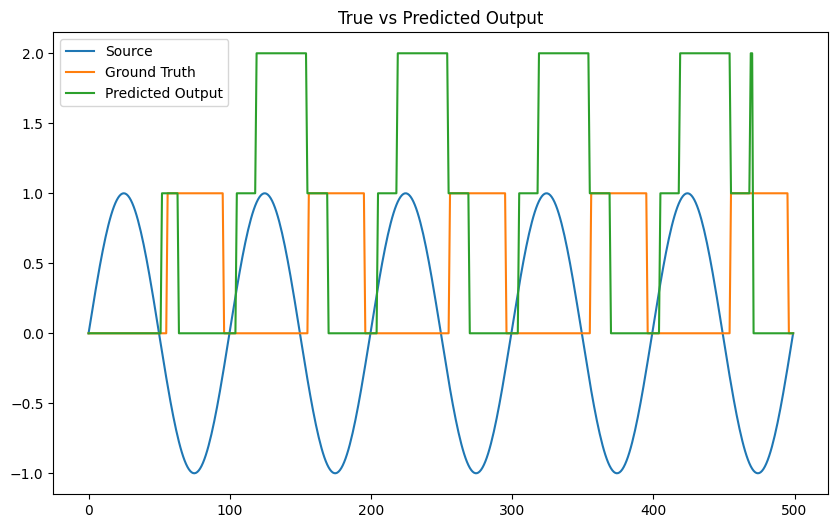

In [91]:
# Test the model on a new sine wave
test_encoder_input, test_decoder_input, test_decoder_target = generate_seq2seq_data(1, sequence_length)
predicted_output = model.predict([test_encoder_input, test_decoder_input])

predicted_classes = np.argmax(predicted_output, axis=-1)

reshaped_data = predicted_classes.reshape(-1)



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_encoder_input[0, :, 0], label='Source')
plt.plot(test_decoder_input[0, :, 0], label='Ground Truth')
plt.plot(reshaped_data, label='Predicted Output')
plt.legend()
plt.title('True vs Predicted Output')
plt.show()

In [94]:
def decode_sequence(model, input_seq):
    # Get the number of batches and sequence length
    batches = input_seq.shape[0]
    seq_len = input_seq.shape[1]

    # Initialize the target sequence with the start token
    target_seq = np.zeros((batches, 1, 3))  # Shape: (batches, 1, 3)
    target_seq[:, 0, 0] = 1  # Start token (class 0)

    # Initialize the decoded sequence
    decoded_sequence = np.zeros((batches, seq_len))  # Shape: (batches, seq_len)

    # Iterate over each timestep
    for i in range(seq_len):
        print(i)

        # Slice the input sequence up to the current timestep
        inp = input_seq[:, :i+1, :]  # Shape: (batches, i+1, 1)

        # Perform prediction
        res = model.predict([inp, target_seq])  # Shape: (batches, i+1, 3)

        # Get the predicted class for the last timestep
        predicted_classes = np.argmax(res[:, -1, :], axis=-1)  # Shape: (batches,)

        # Update the decoded sequence
        decoded_sequence[:, i] = predicted_classes

        # Prepare the next target sequence
        if i < seq_len - 1:
            new_dec = np.zeros((batches, 1, 3))  # Shape: (batches, 1, 3)
            new_dec[np.arange(batches), 0, predicted_classes] = 1
            target_seq = np.concatenate([target_seq, new_dec], axis=1)

    return decoded_sequence

# jopa = np.expand_dims(test_encoder_input, axis=0)
# jopa = np.expand_dims(jopa, axis=-1)
# print(jopa.shape)

jopa = decode_sequence(model, test_encoder_input)

print(jopa.shape)

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━

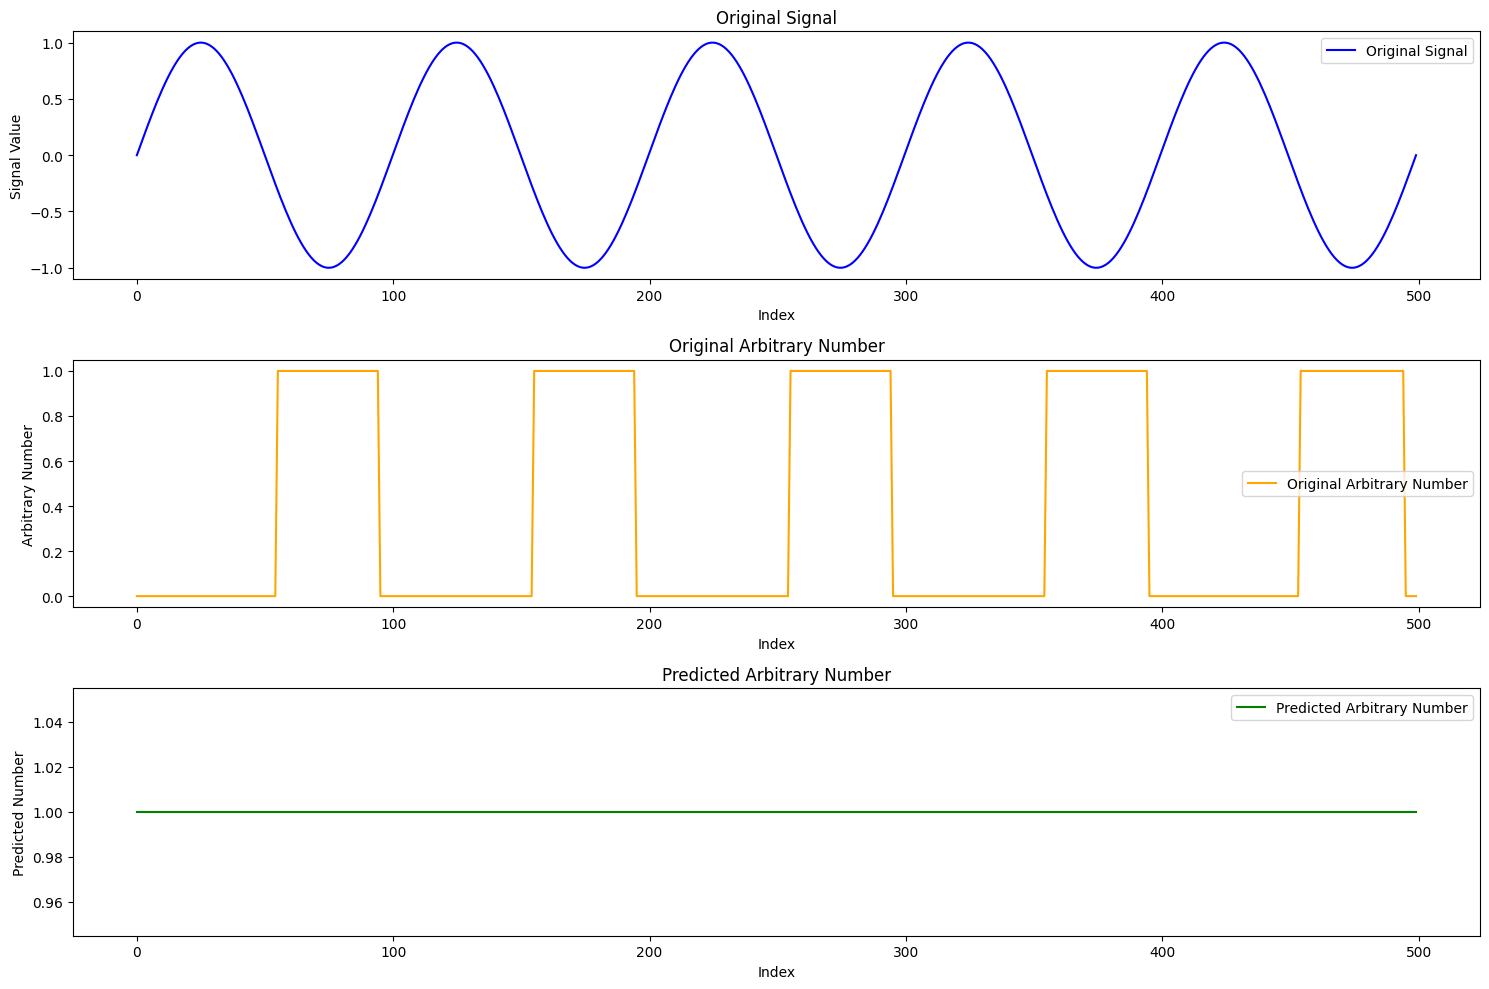

In [95]:
reshaped_data = jopa.reshape(-1)


plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(3, 1, 1)
plt.plot(test_encoder_input[0, :, 0], label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(test_decoder_target[0, :, 0], label='Original Arbitrary Number', color='orange')
plt.title('Original Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Arbitrary Number')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(reshaped_data, label='Predicted Arbitrary Number', color='green')
plt.title('Predicted Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Predicted Number')
plt.legend()

plt.tight_layout()
plt.show()

In [96]:
def decode_sequence(model, input_seq):
    # Get the number of batches and sequence length
    batches = input_seq.shape[0]
    seq_len = input_seq.shape[1]

    # Initialize the target sequence with zeros
    target_seq = np.zeros((batches, seq_len, 3))  # Shape: (batches, seq_len, 3)
    target_seq[:, 0, 0] = 1  # Start token (class 0)

    # Initialize the decoded sequence
    decoded_sequence = np.zeros((batches, seq_len))  # Shape: (batches, seq_len)

    # Iterate over each timestep
    for i in range(seq_len):
        print(f"Processing timestep {i}")

        # Slice the input sequence up to the current timestep
        inp = input_seq[:, :i+1, :]  # Shape: (batches, i+1, 1)

        # Slice the target sequence up to the current timestep
        current_target_seq = target_seq[:, :i+1, :]  # Shape: (batches, i+1, 3)

        # Perform prediction
        res = model.predict([inp, current_target_seq])  # Shape: (batches, i+1, 3)

        # Get the predicted class for the last timestep
        predicted_classes = np.argmax(res[:, -1, :], axis=-1)  # Shape: (batches,)

        # Update the decoded sequence
        decoded_sequence[:, i] = predicted_classes

        # Prepare the next target sequence (only update the next timestep)
        if i < seq_len - 1:
            target_seq[:, i+1, :] = 0  # Reset the next timestep
            target_seq[np.arange(batches), i+1, predicted_classes] = 1  # Set the predicted class

    return decoded_sequence

jopa = decode_sequence(model, test_encoder_input)

print(jopa.shape)

Processing timestep 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Processing timestep 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Processing timestep 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processing timestep 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Processing timestep 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing timestep 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processing timestep 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Processing timestep 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Processing timestep 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Processing timestep 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processing timestep 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing timestep 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing timestep 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing timestep 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing timestep 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Processing timestep 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Processing timestep 16
1/1 ━━━━━━━

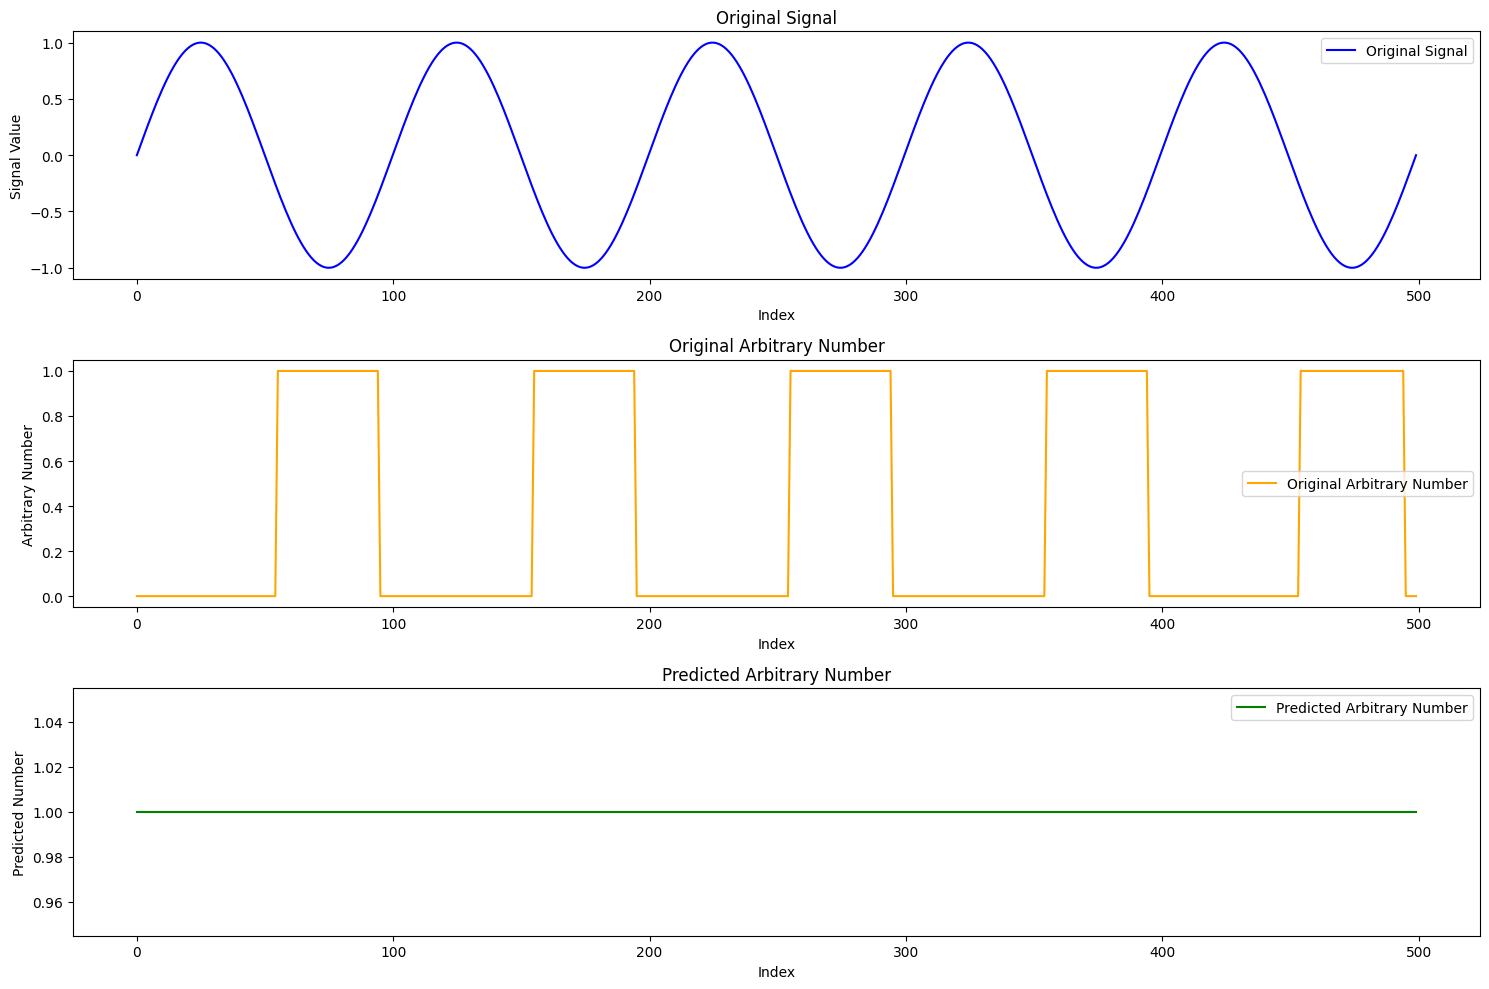

In [97]:
reshaped_data = jopa.reshape(-1)


plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(3, 1, 1)
plt.plot(test_encoder_input[0, :, 0], label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(test_decoder_target[0, :, 0], label='Original Arbitrary Number', color='orange')
plt.title('Original Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Arbitrary Number')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(reshaped_data, label='Predicted Arbitrary Number', color='green')
plt.title('Predicted Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Predicted Number')
plt.legend()

plt.tight_layout()
plt.show()